# Assignment Week 9: House Price Regression using CNN

## Student ID: 250850926

In this lab we will show how to work with mixed data, also called multimodal learning, using deep learning. Mixed data is anything that is not just one type of data, such as mixing traditional structured data with images, or with audio, video, etc. The possibilities are endless!

We will compare a model using the structured data we have available, a model using only the images available and finally a model combining both inputs. This week's work may be too much for your personal computer to handle, so just work on a reduced sample if you see the process taking too much time. You can also just run the assignment in the cloud using either [Google Colab](https://colab.research.google.com/) or [Kaggle Kernels](https://www.kaggle.com/kernels), activiting a GPU environment (In Colab: Navigate to Edit→Notebook Settings and select GPU from the Hardware Accelerator drop-down. For Kaggle Kernels, [follow these instructions](https://www.kaggle.com/dansbecker/running-kaggle-kernels-with-a-gpu)).


## Packages

You will need to install the `pytorch` and `torchvision` packages.
To do so, I suggest starting a terminal by choosing File -> New -> Terminal from the JupyterLab menu, and running
`pip install torch torchvision`

In [1]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
import numpy as np
import pandas as pd
from IPython.display import Image
import torch
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from typing import Dict, Any
import os

%matplotlib inline

def live_plot(loss, train_acc, valid_acc=None, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(loss, label='Training Loss', color='red')
    ax1.legend(loc='lower left')
    ax1.set_ylabel('Mean Square Error Loss')
    ax2 = ax1.twinx()
    ax2.plot(train_acc, label='Training MSE', color='green')
    if valid_acc is not None:
        ax2.plot(valid_acc, label='Validation MSE', color='blue')
    ax2.legend(loc='lower right')
    ax2.set_ylabel('MSE')
    ax2.set_xlabel('Epoch')
    plt.title(title)
    plt.show()

## Data Import and Preprocessing

The objective of the problem is to create a model that predicts house prices using the property's basic information (Bedrooms, bathrooms, area in sqft, zipcode) and a collage of four images in the house. Download the zip file from OWL and decompress it in the folder you are working on. Alternatively, you can run these lines of code if you are using Colab

In [2]:
# Download and unzip the data. Uncomment if you are using a cloud environment.
#!gdown https://drive.google.com/uc?id=1XZGDY0XVHNDawfMymX7d1BRO5a17KIN5
#!!unzip HousesDatasetClean.zip

The data has the following structured attributes, in the file ``HousesInfo.csv``:

- Number of bedrooms and bathrooms.
- Surface area of the house.
- Zipcode the house is located in (Categorical. We'll ignore it in this assignment.)
- **House price (target variable)**.

Run this code to load the data.

In [3]:
HouseData = pd.read_csv('HousesDatasetClean/HousesInfo.csv')
HouseData.drop(columns='zipcode', inplace=True)
HouseData.describe()

,bedrooms,bathrooms,area,price
count,535.000000,535.000000,535.000000,5.350000e+02
mean,3.377570,2.664953,2364.904673,5.893628e+05
std,1.160952,0.995077,1224.556982,5.090261e+05
min,1.000000,1.000000,701.000000,2.200000e+04
25%,3.000000,2.000000,1440.000000,2.492000e+05
50%,3.000000,2.500000,2078.000000,5.290000e+05
75%,4.000000,3.000000,3067.500000,7.285000e+05
max,10.000000,7.000000,9583.000000,5.858000e+06


And each element comes with a collage of four pictures representing different parts of the house. Here is an example. 

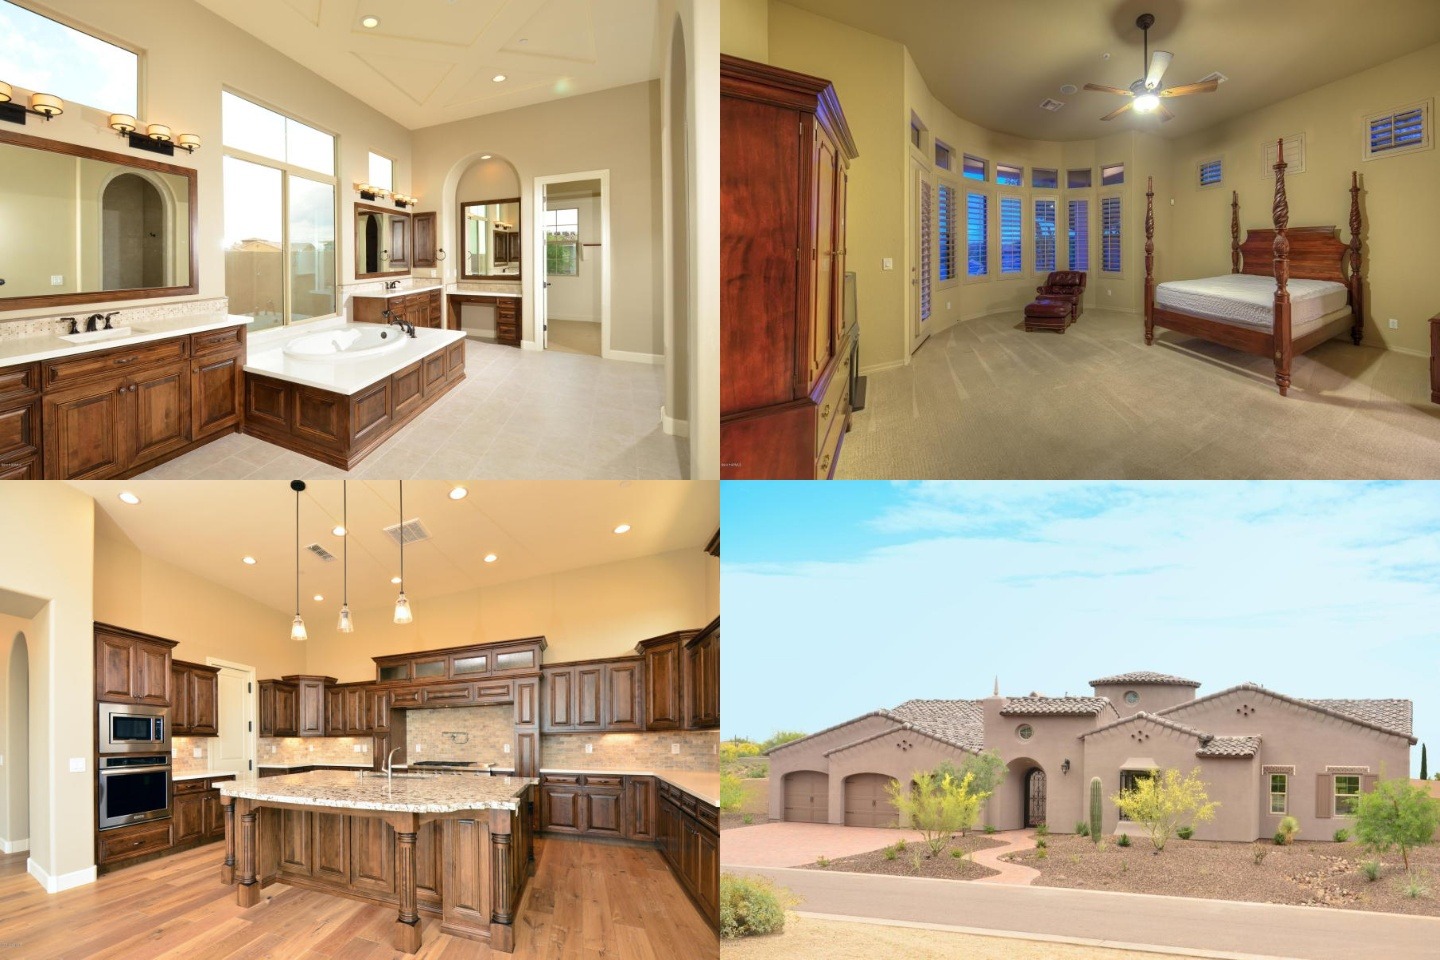

In [4]:
Image(filename='HousesDatasetClean/1/4.jpg')

**For every element in the HouseData dataset, there is a corresponding image in the HouseDatasetClean folder, following the same index. So, for index 0 of the dataset, there is a picture 0.jpg in the HouseDatasetClean folder.**

## Task 1: Non-Linear Structured Model in PyTorch (30 pts)

For the first task, build a model in PyTorch that takes bedrooms, bathrooms, and the area variables and predicts the price of the house. For this we first need a dataset iterator, created below. To read more about data iterators, [read this explanation](https://pytorch.org/docs/stable/data.html).

In [5]:
# Data iterators. Run first.
class StructuredDataset(Dataset):
    def __init__(self, x, y):
        super(StructuredDataset, self).__init__()
        assert x.shape[0] == y.shape[0]
        if torch.cuda.is_available():
            device = 'cuda'
        else:
            device = 'cpu'
        self.x_data = torch.as_tensor(x, device=device, dtype=torch.float)
        self.y_data = torch.as_tensor(y, device=device, dtype=torch.float)


    def __len__(self):
        return self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]


# Load data into 'flattened' NumPy arrays [5 pts]
train, test = train_test_split(HouseData, 
                               test_size = 0.3,
                               random_state = 20201207)


# Normalize the data
normalizer = StandardScaler()
train = normalizer.fit_transform(train)
test = normalizer.transform(test)

# Define the dataset
traindata = StructuredDataset(train[:, :-1], train[:, -1])

# Create iterator. Pass this to the enumerate function.
batch_size = 32
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True)

This has created a `trainloader` object that shuffles the dataset and pulls examples. We can use this to train our neural network. Now we can start creating the model, you'll take it from here. First:

a. Create a model in PyTorch that predicts the price of the house using the other varibles. Use the following architecture:

- [ReLU activation functions](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) in all layers, including the output layer.
- SGD optimizer with a learning rate of 0.01
- Mean square error loss function ([MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)).
- Two hidden layers with 1024 neurons each
- One output layer with an adequate number of neurons in the output layer for a regression problem.

You should see something like this after creating your model.

![imagen.png](attachment:1d617aff-c832-48bd-a0f9-fa3e5e4b4f44.png)

In [6]:
# Define the architecture [20 pts]

class NonLinearModel(torch.nn.Module):

    def __init__(self, input_size, num_classes, max_iter=1000, lr=1e-3):

        super().__init__()

        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=1024) # hidden layer 1
        self.activation1 = torch.nn.ReLU()
        self.dense2 = torch.nn.Linear(in_features=1024, out_features=1024) # hidden layer 2
        self.activation2 = torch.nn.ReLU()
        self.dense3 = torch.nn.Linear(in_features=1024, out_features=num_classes)
        self.activation3 = torch.nn.ReLU()

    def forward(self, X):
        X = self.dense1(X)  
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        X = self.dense3(X)
        X = self.activation3(X)
        return X


In [7]:
#Initiate the model. Result should look like the example above.
num_features = train.shape[1] - 1
num_classes = 1
model = NonLinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

print(model)


NonLinearModel(
  (dense1): Linear(in_features=3, out_features=1024, bias=True)
  (activation1): ReLU()
  (dense2): Linear(in_features=1024, out_features=1024, bias=True)
  (activation2): ReLU()
  (dense3): Linear(in_features=1024, out_features=1, bias=True)
  (activation3): ReLU()
)


b. Train the model until you obtain convergence. Plot the error over the train set as you train. **Written answer: Can the model capture the price variations with the data you have? Why? Why not?**

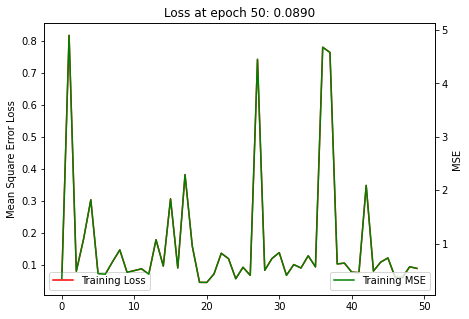

In [8]:
# Train! [10 pts]
losses = []
mse = []
for epoch in range(50):
    # Keep track of total losses
    loss = 0
    for i, data in enumerate(trainloader, 0):
        X, y = data
        optimizer.zero_grad()
        # Get the prediction
        yp = model(X) 
        # Calculate the loss
        y = y.unsqueeze(1)
        loss = criterion(yp, y)
        # Backpropagate
        loss.backward()
        # Optimize weights
        optimizer.step()
        # Getting average loss
        loss += loss.item()
        if i % 12 == 11:
            with torch.no_grad():
                losses.append(loss/12)
                y_pred = model.forward(X)
                y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
                mse.append(mean_squared_error(y_true=y, y_pred=y_pred))
                live_plot(losses, mse, title=f"Loss at epoch {epoch + 1}: {loss/12:.4f}")
                loss = 0


**Written answer here.** This model never really converges (I even tried with 500+ epochs). It can't capture the price variations because there isn't enough data (only about 500 samples) and there aren't enough features for the neural network to learn from. It seems as though it is learning randomly.

## Task 2: Tweaking the model. [45 pts]

Now, repeat Task 1, but modify the following parameters:

a. Number of hidden layers. Try using just one and the two you used above.

b. Neurons in the hidden layer. Try 512, 1024 and 2048 (keep the same number in both layers when using 2).

c. Learning rate. Reduce it to $10^{-4}$ and increase it to $10^{-1}$.

**Written answer: Can you beat the original model in test set MSE? What combination of parameters leads to a better solution? Why do you think this is? What parameters are more important?**

In [9]:
# You'll need several cells of code. Add as many as you need!
class NonLinearModel1(torch.nn.Module):

    def __init__(self, input_size, num_classes, neurons, max_iter=1000, lr=1e-3):

        super().__init__()

        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=neurons) # hidden layer 1
        self.activation1 = torch.nn.ReLU()
        self.dense2 = torch.nn.Linear(in_features=neurons, out_features=num_classes)
        self.activation2 = torch.nn.ReLU()

    def forward(self, X):
        X = self.dense1(X)  
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        return X

class NonLinearModel2(torch.nn.Module):

    def __init__(self, input_size, num_classes, neurons, max_iter=1000, lr=1e-3):

        super().__init__()

        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=neurons) # hidden layer 1
        self.activation1 = torch.nn.ReLU()
        self.dense2 = torch.nn.Linear(in_features=neurons, out_features=neurons) # hidden layer 2
        self.activation2 = torch.nn.ReLU()
        self.dense3 = torch.nn.Linear(in_features=neurons, out_features=num_classes)
        self.activation3 = torch.nn.ReLU()

    def forward(self, X):
        X = self.dense1(X)  
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        X = self.dense3(X)
        X = self.activation3(X)
        return X


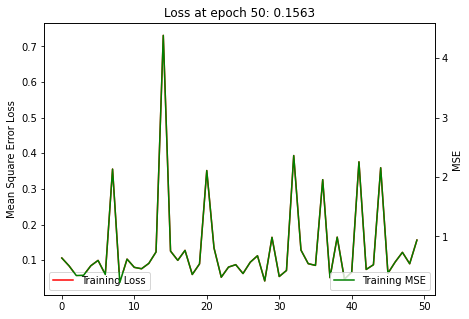

In [10]:
neurons = 512
model = NonLinearModel1(num_features, num_classes, neurons)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

losses = []
mse = []
for epoch in range(50):
    # Keep track of total losses
    loss = 0
    for i, data in enumerate(trainloader, 0):
        X, y = data
        optimizer.zero_grad()
        # Get the prediction
        yp = model(X) 
        # Calculate the loss
        y = y.unsqueeze(1)
        loss = criterion(yp, y)
        # Backpropagate
        loss.backward()
        # Optimize weights
        optimizer.step()
        # Getting average loss
        loss += loss.item()
        if i % 12 == 11:
            with torch.no_grad():
                losses.append(loss/12)
                y_pred = model.forward(X)
                y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
                mse.append(mean_squared_error(y_true=y, y_pred=y_pred))
                live_plot(losses, mse, title=f"Loss at epoch {epoch + 1}: {loss/12:.4f}")
                loss = 0


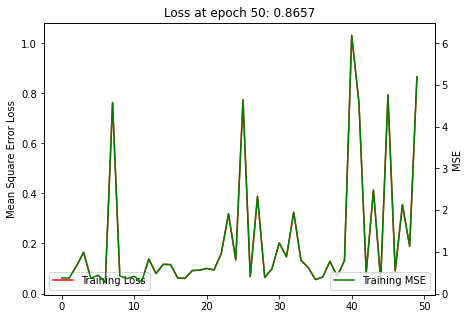

In [11]:
neurons = 512
model = NonLinearModel1(num_features, num_classes, neurons)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()

losses = []
mse = []
for epoch in range(50):
    # Keep track of total losses
    loss = 0
    for i, data in enumerate(trainloader, 0):
        X, y = data
        optimizer.zero_grad()
        # Get the prediction
        yp = model(X) 
        # Calculate the loss
        y = y.unsqueeze(1)
        loss = criterion(yp, y)
        # Backpropagate
        loss.backward()
        # Optimize weights
        optimizer.step()
        # Getting average loss
        loss += loss.item()
        if i % 12 == 11:
            with torch.no_grad():
                losses.append(loss/12)
                y_pred = model.forward(X)
                y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
                mse.append(mean_squared_error(y_true=y, y_pred=y_pred))
                live_plot(losses, mse, title=f"Loss at epoch {epoch + 1}: {loss/12:.4f}")
                loss = 0


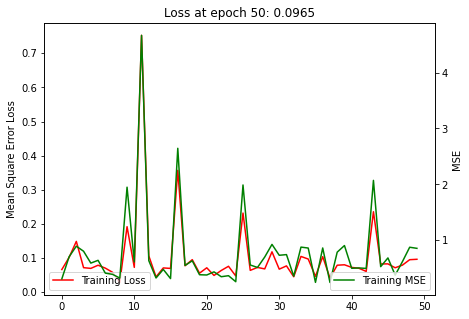

In [12]:
neurons = 1024
model = NonLinearModel1(num_features, num_classes, neurons)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

losses = []
mse = []
for epoch in range(50):
    # Keep track of total losses
    loss = 0
    for i, data in enumerate(trainloader, 0):
        X, y = data
        optimizer.zero_grad()
        # Get the prediction
        yp = model(X) 
        # Calculate the loss
        y = y.unsqueeze(1)
        loss = criterion(yp, y)
        # Backpropagate
        loss.backward()
        # Optimize weights
        optimizer.step()
        # Getting average loss
        loss += loss.item()
        if i % 12 == 11:
            with torch.no_grad():
                losses.append(loss/12)
                y_pred = model.forward(X)
                y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
                mse.append(mean_squared_error(y_true=y, y_pred=y_pred))
                live_plot(losses, mse, title=f"Loss at epoch {epoch + 1}: {loss/12:.4f}")
                loss = 0


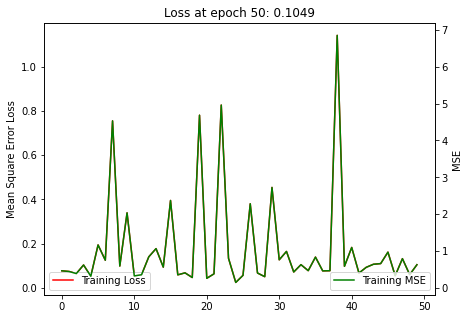

In [13]:
neurons = 1024
model = NonLinearModel1(num_features, num_classes, neurons)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()

losses = []
mse = []
for epoch in range(50):
    # Keep track of total losses
    loss = 0
    for i, data in enumerate(trainloader, 0):
        X, y = data
        optimizer.zero_grad()
        # Get the prediction
        yp = model(X) 
        # Calculate the loss
        y = y.unsqueeze(1)
        loss = criterion(yp, y)
        # Backpropagate
        loss.backward()
        # Optimize weights
        optimizer.step()
        # Getting average loss
        loss += loss.item()
        if i % 12 == 11:
            with torch.no_grad():
                losses.append(loss/12)
                y_pred = model.forward(X)
                y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
                mse.append(mean_squared_error(y_true=y, y_pred=y_pred))
                live_plot(losses, mse, title=f"Loss at epoch {epoch + 1}: {loss/12:.4f}")
                loss = 0


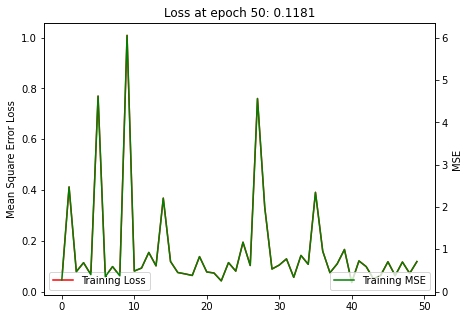

In [14]:
neurons = 2048
model = NonLinearModel1(num_features, num_classes, neurons)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

losses = []
mse = []
for epoch in range(50):
    # Keep track of total losses
    loss = 0
    for i, data in enumerate(trainloader, 0):
        X, y = data
        optimizer.zero_grad()
        # Get the prediction
        yp = model(X) 
        # Calculate the loss
        y = y.unsqueeze(1)
        loss = criterion(yp, y)
        # Backpropagate
        loss.backward()
        # Optimize weights
        optimizer.step()
        # Getting average loss
        loss += loss.item()
        if i % 12 == 11:
            with torch.no_grad():
                losses.append(loss/12)
                y_pred = model.forward(X)
                y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
                mse.append(mean_squared_error(y_true=y, y_pred=y_pred))
                live_plot(losses, mse, title=f"Loss at epoch {epoch + 1}: {loss/12:.4f}")
                loss = 0


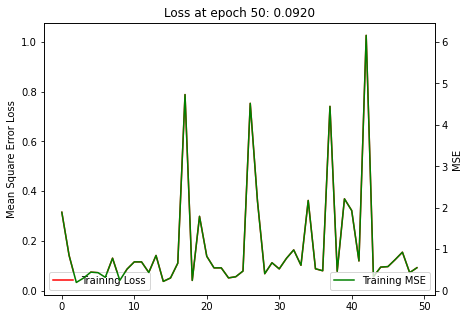

In [15]:
neurons = 2048
model = NonLinearModel1(num_features, num_classes, neurons)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()

losses = []
mse = []
for epoch in range(50):
    # Keep track of total losses
    loss = 0
    for i, data in enumerate(trainloader, 0):
        X, y = data
        optimizer.zero_grad()
        # Get the prediction
        yp = model(X) 
        # Calculate the loss
        y = y.unsqueeze(1)
        loss = criterion(yp, y)
        # Backpropagate
        loss.backward()
        # Optimize weights
        optimizer.step()
        # Getting average loss
        loss += loss.item()
        if i % 12 == 11:
            with torch.no_grad():
                losses.append(loss/12)
                y_pred = model.forward(X)
                y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
                mse.append(mean_squared_error(y_true=y, y_pred=y_pred))
                live_plot(losses, mse, title=f"Loss at epoch {epoch + 1}: {loss/12:.4f}")
                loss = 0


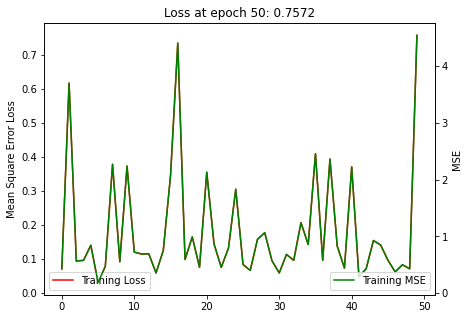

In [16]:
neurons = 512
model = NonLinearModel2(num_features, num_classes, neurons)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

losses = []
mse = []
for epoch in range(50):
    # Keep track of total losses
    loss = 0
    for i, data in enumerate(trainloader, 0):
        X, y = data
        optimizer.zero_grad()
        # Get the prediction
        yp = model(X) 
        # Calculate the loss
        y = y.unsqueeze(1)
        loss = criterion(yp, y)
        # Backpropagate
        loss.backward()
        # Optimize weights
        optimizer.step()
        # Getting average loss
        loss += loss.item()
        if i % 12 == 11:
            with torch.no_grad():
                losses.append(loss/12)
                y_pred = model.forward(X)
                y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
                mse.append(mean_squared_error(y_true=y, y_pred=y_pred))
                live_plot(losses, mse, title=f"Loss at epoch {epoch + 1}: {loss/12:.4f}")
                loss = 0


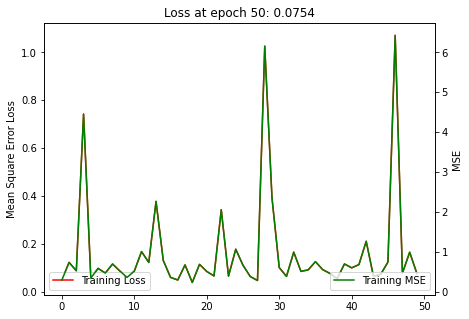

In [17]:
neurons = 512
model = NonLinearModel2(num_features, num_classes, neurons)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()

losses = []
mse = []
for epoch in range(50):
    # Keep track of total losses
    loss = 0
    for i, data in enumerate(trainloader, 0):
        X, y = data
        optimizer.zero_grad()
        # Get the prediction
        yp = model(X) 
        # Calculate the loss
        y = y.unsqueeze(1)
        loss = criterion(yp, y)
        # Backpropagate
        loss.backward()
        # Optimize weights
        optimizer.step()
        # Getting average loss
        loss += loss.item()
        if i % 12 == 11:
            with torch.no_grad():
                losses.append(loss/12)
                y_pred = model.forward(X)
                y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
                mse.append(mean_squared_error(y_true=y, y_pred=y_pred))
                live_plot(losses, mse, title=f"Loss at epoch {epoch + 1}: {loss/12:.4f}")
                loss = 0

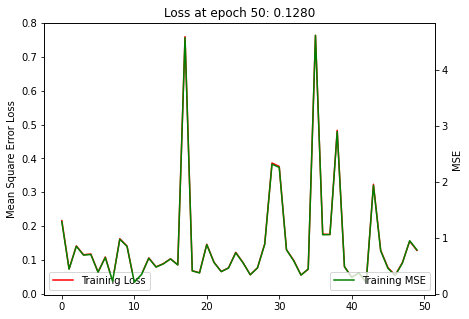

In [18]:
neurons = 1024
model = NonLinearModel2(num_features, num_classes, neurons)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

losses = []
mse = []
for epoch in range(50):
    # Keep track of total losses
    loss = 0
    for i, data in enumerate(trainloader, 0):
        X, y = data
        optimizer.zero_grad()
        # Get the prediction
        yp = model(X) 
        # Calculate the loss
        y = y.unsqueeze(1)
        loss = criterion(yp, y)
        # Backpropagate
        loss.backward()
        # Optimize weights
        optimizer.step()
        # Getting average loss
        loss += loss.item()
        if i % 12 == 11:
            with torch.no_grad():
                losses.append(loss/12)
                y_pred = model.forward(X)
                y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
                mse.append(mean_squared_error(y_true=y, y_pred=y_pred))
                live_plot(losses, mse, title=f"Loss at epoch {epoch + 1}: {loss/12:.4f}")
                loss = 0


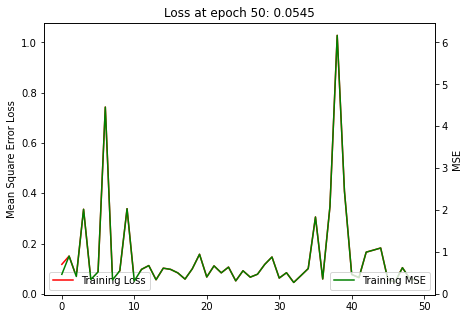

In [19]:
neurons = 1024
model = NonLinearModel2(num_features, num_classes, neurons)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()

losses = []
mse = []
losses = []
mse = []
for epoch in range(50):
    # Keep track of total losses
    loss = 0
    for i, data in enumerate(trainloader, 0):
        X, y = data
        optimizer.zero_grad()
        # Get the prediction
        yp = model(X) 
        # Calculate the loss
        y = y.unsqueeze(1)
        loss = criterion(yp, y)
        # Backpropagate
        loss.backward()
        # Optimize weights
        optimizer.step()
        # Getting average loss
        loss += loss.item()
        if i % 12 == 11:
            with torch.no_grad():
                losses.append(loss/12)
                y_pred = model.forward(X)
                y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
                mse.append(mean_squared_error(y_true=y, y_pred=y_pred))
                live_plot(losses, mse, title=f"Loss at epoch {epoch + 1}: {loss/12:.4f}")
                loss = 0


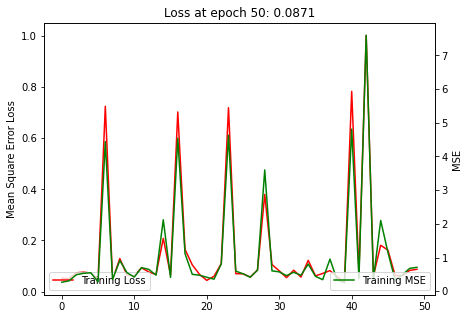

In [20]:
neurons = 2048
model = NonLinearModel2(num_features, num_classes, neurons)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

losses = []
mse = []
for epoch in range(50):
    # Keep track of total losses
    loss = 0
    for i, data in enumerate(trainloader, 0):
        X, y = data
        optimizer.zero_grad()
        # Get the prediction
        yp = model(X) 
        # Calculate the loss
        y = y.unsqueeze(1)
        loss = criterion(yp, y)
        # Backpropagate
        loss.backward()
        # Optimize weights
        optimizer.step()
        # Getting average loss
        loss += loss.item()
        if i % 12 == 11:
            with torch.no_grad():
                losses.append(loss/12)
                y_pred = model.forward(X)
                y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
                mse.append(mean_squared_error(y_true=y, y_pred=y_pred))
                live_plot(losses, mse, title=f"Loss at epoch {epoch + 1}: {loss/12:.4f}")
                loss = 0


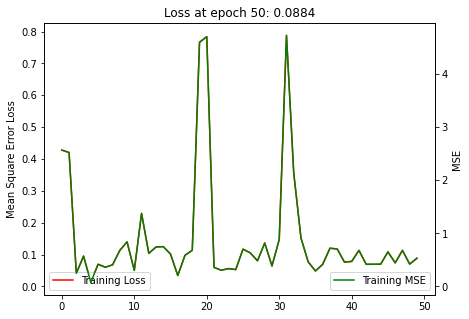

In [21]:
neurons = 2048
model = NonLinearModel2(num_features, num_classes, neurons)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()

losses = []
mse = []
for epoch in range(50):
    # Keep track of total losses
    loss = 0
    for i, data in enumerate(trainloader, 0):
        X, y = data
        optimizer.zero_grad()
        # Get the prediction
        yp = model(X) 
        # Calculate the loss
        y = y.unsqueeze(1)
        loss = criterion(yp, y)
        # Backpropagate
        loss.backward()
        # Optimize weights
        optimizer.step()
        # Getting average loss
        loss += loss.item()
        if i % 12 == 11:
            with torch.no_grad():
                losses.append(loss/12)
                y_pred = model.forward(X)
                y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
                mse.append(mean_squared_error(y_true=y, y_pred=y_pred))
                live_plot(losses, mse, title=f"Loss at epoch {epoch + 1}: {loss/12:.4f}")
                loss = 0


**Written answer here.** 
None of the models really 'beat' the original model MSE, since they never converge and the MSEs are all over the place. Even when using 300+ epochs for each, they still do not converge. 


There's not much of a difference between the performance of the models, and they all perform pretty randomly because they never actually converge (unsure if this is something I did wrong, but upon examining the dataset, it seems too small (~500 samples is not enough) and too random (not much correlation between the features and different sample outputs)). 


However, theoretically, learning rate would be an important parameter. This is because a learning rate that is too large is learning the weights too fast and making them too large, skipping over an optimal result. I'd also assume that a neural network with more neurons would perform better as well, however too many neurons would cause overfitting.


Overall, there isn't enough data and features for the model to learn a concrete trend. 

*Note: You are in fact doing a gridsearch for the best parameters. You should in theory do this using cross-validation as we did in the last assignment, but for neural networks this can be infeasible without using GPUs so we will ignore it for this assignment. Just use the iterator we already have defined.*

## Task 3: Convolutional Neural Network [25 pts]

Now we will train a custom convolutional neural network that takes the images, creates a train / test split, and calculates the price of the house given the images. As image datasets can be very large, we cannot simply load them into memory. We must create iterators that load, on demand, the images we need. For this we use the [``ImageFolder``](https://pytorch.org/vision/stable/datasets.html#imagefolder) class, that does exactly that. However, as this is a regression problem, we need to extend this class to be able to handle regression data. I do this when I create the ``RegressionImageFolder`` below. Then, I simply load the dataset, as follows:

In [22]:
# How we will transform the images.
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(255),   # Scale images from 0-255 to 0-1
                                            torchvision.transforms.ToTensor()])   # Transform everything to a pytorch tensor

# Add path to images.
ImagePath = 'HousesDatasetClean/1' # This works on Windows. In OSX or Linux (Colab), use 'HousesDatasetClean/1'
HouseData['path'] = [os.path.join(ImagePath, str(i) + '.jpg') for i in HouseData.index.values]   # Create the image path
HouseData.head()  # See what comes out

# Read the data from the folder
class RegressionImageFolder(torchvision.datasets.ImageFolder):
    def __init__(
        self, root: str, image_scores: Dict[str, float], **kwargs: Any
    ) -> None:
        super().__init__(root, **kwargs)
        paths, _ = zip(*self.imgs)
        self.targets = [image_scores[path] for path in paths]
        self.samples = self.imgs = list(zip(paths, self.targets))

# In Torch I can't see the labels, so I'll normalize the whole thing.
HouseData['price'] = (HouseData['price'] - np.mean(HouseData['price'])) / np.std(HouseData['price'])

# Create the data loader
img_dataset = RegressionImageFolder('HousesDatasetClean', transform=transform,
                                   image_scores = dict(zip(HouseData['path'], HouseData['price'])))

# Create the dataloaders
dataset_train, dataset_valid = torch.utils.data.random_split(img_dataset, (375, 160))




batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=dataset_valid, shuffle=False, batch_size=batch_size)

a. Now we can train our convolutional neural network. The following code creates a convolutional architecture that you are asked to complete. Write the final layers so it has two ReLU layers,  with 1024 neurons (note the output size from the last convolutional layer is 23940, this is your input size for the first dense layer) and one output layer of sufficient size. You may do this as the model in the previous tasks, or reading about the [Sequential class](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) in pytorch here. [10 pts]

In [23]:
class ConvNet(torch.nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        self.cnn_layers = torch.nn.Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            torch.nn.Conv2d(64, 4, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # COMPLETE HERE
        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(in_features=23940, out_features=1024),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(in_features=1024, out_features=1),
            torch.nn.ReLU(inplace=True),
        )

    # Defining the forward pass
    def forward(self, x):
        x = x
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        # COMPLETE HERE
        x = self.linear_layers(x)

        # Return model
        return x

b. Initiate the model with an SGD optimizer with a learning rate of 0.001 and an MSE loss. [5 pts] The model structure should look similar to this (if you used the Sequential class):
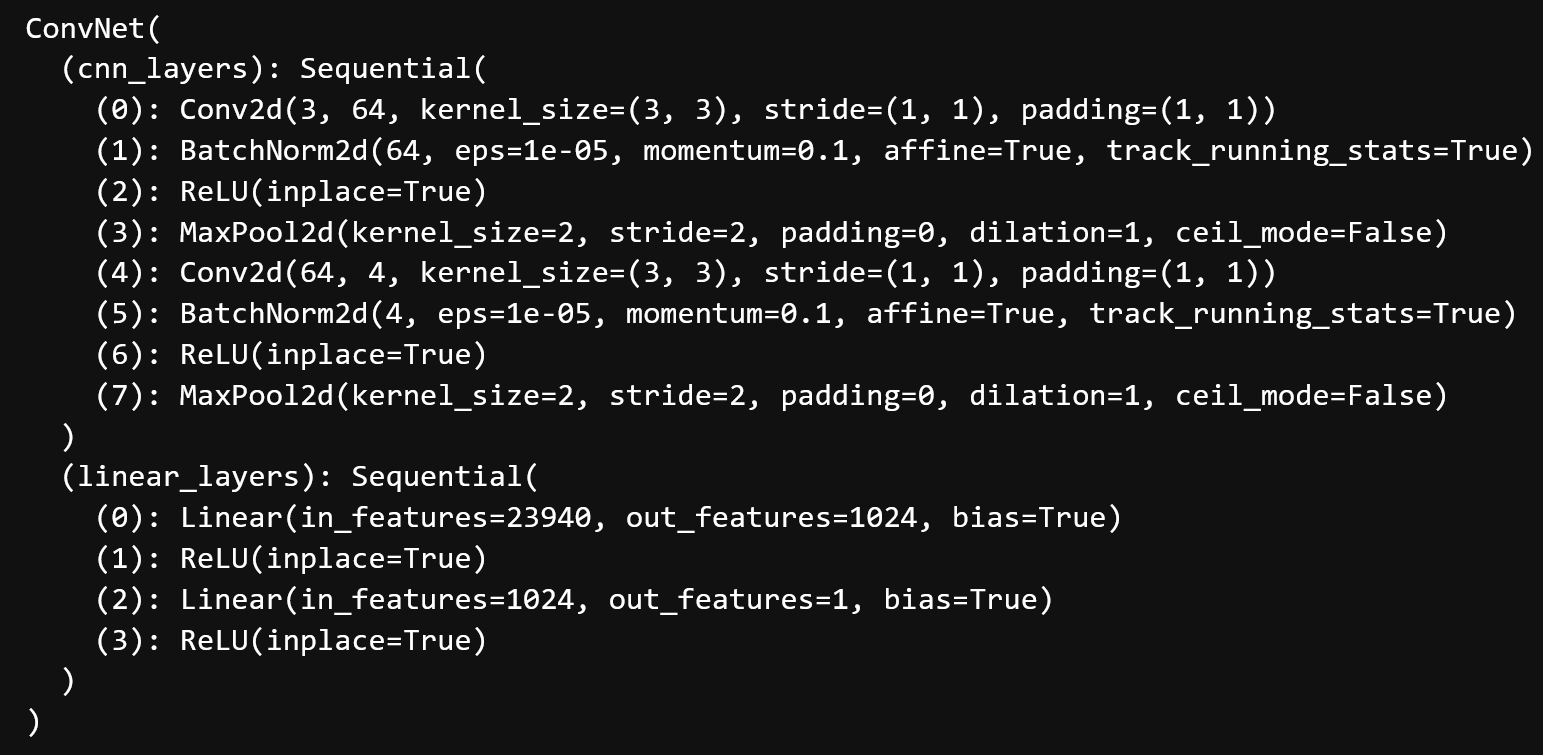

In [24]:
# Your code here
model = ConvNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

print(model)

ConvNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=23940, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1, bias=True)
    (3): ReLU(inplace=True)
  )
)


c. Train the model using the dataset above for 10 epochs, and calculate the test set data (read [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) to learn to apply the model after it is trained). Plot the train and test losses.

**Written answer: What can you say about the model? Is it able to predict the prices? How does it compare with the structured data model? Discuss your results.**  [10 pts]

**Hint: If you run out of memory while training, reduce the batch size and restart the notebook kernel running only starting from Task 3**

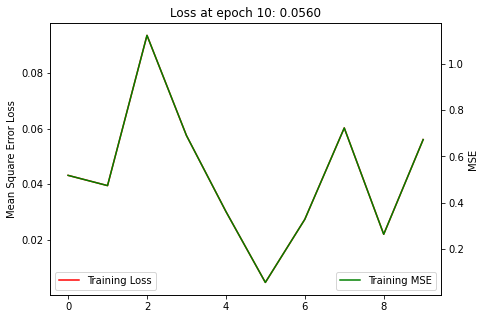

In [25]:
# Train! [5 pts]
losses = []
mse = []
for epoch in range(10):
    # Keep track of total losses
    loss = 0
    for i, data in enumerate(train_loader, 0):
        X, y = data
        optimizer.zero_grad()
        # Get the prediction
        yp = model(X) 
        # Calculate the loss
        y = y.unsqueeze(1)
        loss = criterion(yp, y.float())
        # Backpropagate
        loss.backward()
        # Optimize weights
        optimizer.step()
        # Getting average loss
        loss += loss.item()
        if i % 24 == 23:
            with torch.no_grad():
                losses.append(loss/24)
                y_pred = model.forward(X)
                y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
                mse.append(mean_squared_error(y_true=y, y_pred=y_pred))
                live_plot(losses, mse, title=f"Loss at epoch {epoch + 1}: {loss/24:.4f}")
                loss = 0

In [26]:
dataiter = iter(val_loader)
images, labels = dataiter.next()
outputs = model(images)
mse_test = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        mse_test.append(mean_squared_error(y_true=labels, y_pred=outputs))

print(mse)


[0.5179567024601862, 0.47375727874382084, 1.122237182084478, 0.6900981478901381, 0.3621056928697223, 0.055787036067091976, 0.3281661287666143, 0.7226365709426166, 0.2637300956764483, 0.6725291822444767]


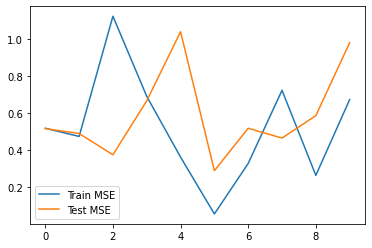

In [27]:
# Plot the losses [2 pts]
plt.plot(mse, label='Train MSE')
plt.plot(mse_test, label='Test MSE')
plt.legend()
plt.show()

**Written answer: [3 pts]** 

Honestly, I don't know if I messed up somewhere on this assignment because none of the models "worked".

HOWEVER: I am not surprised that ALL of the models performed super randomly. There is not enough data, and there are not enough features for the model to educate itself, and therefore it resorts to guessing prices. The images alone don't give a lot of information, and there are only 500 of them. The model using images cannot predict price because computers do not have the ability (yet) to tell if a house looks "nice" or not according to human standards (unless if I'm wrong and computers are more advanced than I think). For example, When I look at a picture of a bedroom, I can tell if the furniture looks expensive and nice, I can tell if the decor is modern, etc. The same applies to when I look at a picture of a kitchen or a family room. These factors allow me to assess the value of a house. However, the only information a computer gets is a matrix containing the color values of the pixels. With this information, the computer can detect variation in colors, which gives it the ability to map out shapes (so, it can see a bed, a nightstand, etc), but it can't see the value of the furniture with just a picture. All it sees is a bed, it can't determine how "nice" the bed is since this is a standard that can only be assessed by humans.

The data is also highly variable. I have examined it and even I can't make an educated guess on how much a house would be worth based on this information. For example, I found these two samples: house1(3,3,1894,81524,449000) and house2(4,2,2128,81524,249900). House1 and house2 are in the same area (same zip code). House1 has less bedrooms than house2, has a smaller area, however it is MUCH more expensive (449,000 vs 249,900). This illustrates the "randomness" of the data. Especially since there are only 500 samples; this model would need to be fed thousands of different samples to come up with more accurate results and to learn a proper trend. 

As a conclusion, I'm going to assume that the model is guessing random prices and not actually learning.